<a href="https://colab.research.google.com/github/singhjasdeep13/csci166/blob/main/CSCI166_DeepQLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 4.6 MB/s eta 0:00:00


In [ ]:
import random, time
from collections import deque, namedtuple

import gymnasium as gym
import numpy as np
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))

from tqdm.auto import tqdm

n_episodes = 200  # play 200 games
eps = 1.0  # exploration rate, probability of choosing random action
eps_decay = 0.9975  # eps gets multiplied by this number each epoch...
min_eps = 0.1  # ...until this minimum eps is reached
gamma = 0.95  # discount
max_memory_size = 10000  # size of the replay memory
batch_size = 16  # batch size of the neural network training
min_length = 160  # minimum length of the replay memory for training, before it reached this length, no gradient updates happen
memory_parts = [
    "state",
    "action",
    "next_state",
    "reward",
    "done",
]  # nice names for the part of replay memory, otherweise the names are 0-5

Num GPUs Available:  0
Num CPUs Available:  1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Learning A Model

In [ ]:
Memory = namedtuple("Memory", memory_parts)  # a single entry of the memory replay


class ReplayMemory:
    def __init__(self, max_length=None):
        self.max_length = max_length
        self.memory = deque(maxlen=max_length)

    def store(self, data):
        self.memory.append(data)

    def _sample(self, k):
        return random.sample(self.memory, k)

    def structured_sample(self, k):
        batch = self._sample(k)
        result = {}
        for i, part in enumerate(memory_parts):
            result[part] = np.array([row[i] for row in batch])

        return result

    def __len__(self):
        return len(self.memory)

In [ ]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(4,)),  # Define input shape with Input layer
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(2, activation="linear"),  # 2 actions: go left or go right
    ]
)
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
)

In [ ]:
env = gym.make("CartPole-v1")
replay_memory = ReplayMemory(max_length=max_memory_size)

for episode in tqdm(range(n_episodes)):  # tqdm makes a nice proress bar
    state, _ = env.reset()
    done = False

    while not done:
        if random.random() < eps:
            action = env.action_space.sample()  # random action
        else:
            action = model.predict(state[np.newaxis, :], verbose=False).argmax()  # best action according to the model

        next_state, reward, done, _, _ = env.step(action)
        memory = Memory(state, action, next_state, reward, done)
        replay_memory.store(memory)

        if len(replay_memory) >= min_length:
            batch = replay_memory.structured_sample(batch_size)  # get samples from the replay memory

            target_batch = batch["reward"] + gamma * model.predict(batch["next_state"], verbose=False).max(axis=1) * (
                1 - batch["done"]
            )  # R(s, a) + γ·maxₐ N(s') if not a terminal state, otherwise R(s, a)
            targets = model.predict(batch["state"], verbose=False)
            targets[
                range(batch_size), batch["action"]
            ] = target_batch  # set the target for the action that was done and leave the outputs of other 3 actions as they are

            model.fit(batch["state"], targets, verbose=False, batch_size=batch_size)  # train for one epoch

        state = next_state
    if episode % 100 == 0:
      save_path = '/content/drive/My Drive/my_QmodelB_{}iterations.keras'.format(episode)
      print (save_path)
      model.save(save_path)
    eps = max(min_eps, eps * eps_decay)
save_path = '/content/drive/My Drive/my_QmodelB_{}iterations.keras'.format(episode)
print (save_path)
model.save(save_path)

  0%|          | 0/200 [00:00<?, ?it/s]

/content/drive/My Drive/my_QmodelB_0iterations.keras
/content/drive/My Drive/my_QmodelB_100iterations.keras
/content/drive/My Drive/my_QmodelB_199iterations.keras


In [ ]:
eps_decay = 0.999
min_eps = 0.01
eps = 1.0
for i in range(2000):
  eps = max(min_eps, eps * eps_decay)
  if (i % 10==0):
    print (i, eps)

print(eps)

0 0.999
10 0.9890548353295385
20 0.9792086759647052
30 0.9694605362958227
40 0.959809440525076
50 0.9502544225688344
60 0.9407945259609451
70 0.9314288037569908
80 0.9221563184394991
90 0.9129761418240965
100 0.9038873549665959
110 0.8948890480710096
120 0.8859803203984784
130 0.8771602801771059
140 0.8684280445126921
150 0.8597827393003539
160 0.8512234991370281
170 0.8427494672348417
180 0.8343597953353479
190 0.8260536436246144
200 0.8178301806491574
210 0.8096885832327116
220 0.8016280363938307
230 0.7936477332643059
240 0.7857468750083979
250 0.7779246707428734
260 0.7701803374578359
270 0.7625130999383466
280 0.7549221906868242
290 0.7474068498462175
300 0.7399663251239436
310 0.7325998717165821
320 0.7253067522353204
330 0.7180862366321393
340 0.7109376021267352
350 0.7038601331341691
360 0.6968531211932361
370 0.6899158648955466
380 0.6830476698153162
390 0.6762478484398523
400 0.6695157201007336
410 0.662850610905674
420 0.6562518536710664
430 0.6497187878551962
440 0.64325075

# Test Learned Models

In [ ]:
## Choose Model
version = 1
models = [(0, '1X8Zo61WwqucZw-8rlISjmpYv-jxB5BQZ'), (199, '1mD49qotBxiTdwFDumFRLucBVUSAK9nuO')]

!gdown {models[version][1]}
save_path=f'my_QmodelB_{models[version][0]}iterations.keras'
print(save_path)

Downloading...
From: https://drive.google.com/uc?id=1mD49qotBxiTdwFDumFRLucBVUSAK9nuO
To: /content/my_QmodelB_199iterations.keras
100% 147k/147k [00:00<00:00, 77.5MB/s]
my_QmodelB_199iterations.keras


In [ ]:
import matplotlib.pyplot as plt
import gymnasium as gym
import tensorflow as tf

from tensorflow.keras.models import load_model

model = load_model(save_path, compile=False)
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
)

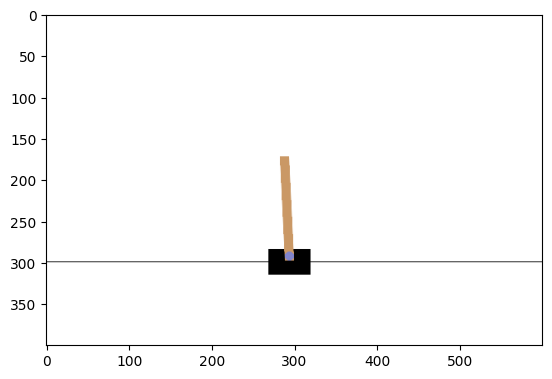

action=0, total_reward=1.0


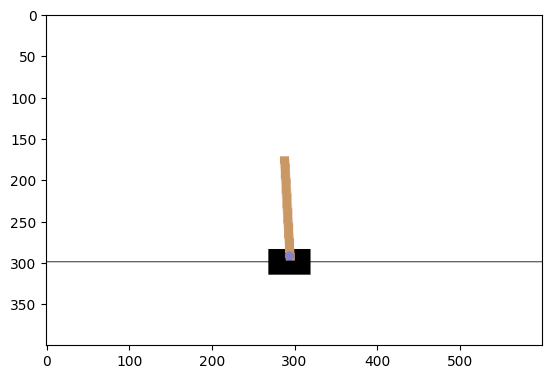

In [ ]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
state, _ = env.reset()
done = False
total_reward = 0
state_image=env.render()
plt.imshow(state_image)
plt.show()

state_image=env.render()
action = model.predict(state[np.newaxis, :], verbose=False).argmax(axis=1)[0]
state, reward, done, _, _ = env.step(action)
total_reward += reward
print (f"{action=}, {total_reward=}")
state_image=env.render()
plt.imshow(state_image)
plt.show()

In [ ]:
env = gym.make("CartPole-v1", render_mode="human")

state, _ = env.reset()
done = False
total_reward = 0

while not done and total_reward < 500:  # force end the game after 500 time steps because the model is too good!
    env.render()
    action = model.predict(state[np.newaxis, :], verbose=False).argmax(axis=1)[0]
    state, reward, done, _, _ = env.step(action)
    total_reward += reward

env.close()
print (f"{total_reward=}")

total_reward=245.0


In [ ]:
env.close()

In your exploration, try rerunning code some number of epochs.  Then try making 2-3 changes and test results.

Changes could include: (1) model definition, (2) epsilon decay, or other algorithmic changes.

Document your idea with the modification, and your results.

# Changes and Results

I changed the default number of iterations to 200 because, without running it locally, 1000 iterations kept timing out for me. Hence I used the 0 and 199 iteration models.




1000 episodes with decay rate of 0.9975 and gamma of 0.95 resulted in total_reward of 234.0

200 episodes with decay rate of 0.9975 and gamma of 0.95 resulted in total_reward of 230.0

500 episodes with decay rate of 0.9975 and gamma of 0.95 resulted in total_reward of 222.0

100 episodes with decay rate of 0.980 and gamma of 0.9 resulted in total_reward of 181.0

2000 episodes with decay rate of 0.999 and gamma of 0.75 resulted in total_reward of 220.0

What I gathered from these tests was that the higher number of episodes with a consistent decay rate and gamma generally produced a higher reward. Changing the gamma produced varying results, sometimes they were higher and other times they were lower regardless of how many times I ran it. Otherwise, I believe balancing these factors can reach total_reward of 500 before 500 time steps.